# Building Optimization with Dask

This notebook uses Dask to parrallize the NSGAII alogrithm.  
Most of this notebook is copied from the "BuildingOptimization" notebook. But, this notebook will skip over concepts unrelated to Dask. Go to Examples/Optimization/BuildingOptimization.ipynb for more details about the notebook.  

### Setup dask
To use Dask setup the scheduler and the workers by runnning the cell below.  
The client object is used to get and set various dask settings such as the number of workers.   

If you're running this notebook locally, you should be able to open the dashboard using the link provided by client.

In [1]:
from dask.distributed import Client

client = Client()
client

c:\users\goh\envs\besos\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:54017 Dashboard: http://127.0.0.1:54020/status,Cluster Workers: 4 Cores: 4 Memory: 8.30 GB


### Building Optimization setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from besos import eppy_funcs as ef
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.optimizer import NSGAII

from platypus.evaluator import MapEvaluator

In [3]:
building = ef.get_building('in.idf') # Load the E+ model in.idf

In [4]:
parameters = []
parameters = expand_plist( # Use helper function to make parameter list
    {'Building 1':                    # Name from IDF Building object
          {'North Axis':(0,359)}}     # Change orientation from North
    )

parameters.append(wwr(RangeParameter(0.1, 0.9))) # Add window-to-wall ratio as a parameter between 0.1 and 0.9 using a custom function

In [5]:
objectives = ['DistrictCooling:Facility', 'DistrictHeating:Facility'] # Use Heating and Cooling (Ideal air loads) as objectives
problem = EPProblem(parameters, objectives) # Make a problem instance from the parameters and objectives

### Set up EnergyPlus evaluator
The Energy Plus evaluator must have `multi = True` to enable multiprocessing.   
This disables the caching functionality of the evaluator which is incompatible with multiprocessing.  
If a distributed network is used, `distributed = True` must also be set in the evaluator.
The `distributed` setting ensures that the eplus configuration files (.idf, .idd, and .epw) are sent to the workers.  

In this cell, a evaluator is created and one simulation is run as a test

In [6]:
evaluatorEP = EvaluatorEP(problem, building, multi=True) # outputdir must exist; E+ files will be written there
runs = pd.DataFrame.from_dict({'0': [180, 0.5]}, orient='index') # Make a dataframe of runs with one entry for South and 50% glazing
outputs = evaluatorEP.df_apply(runs) # Run this as a test
outputs

c:\users\goh\envs\besos\lib\site-packages\distributed\worker.py:3221: UserWarning: Large object of size 1.21 MB detected in task graph: 
  (     0    1
0  180  0.5, <besos.evaluator.Evaluat ... 0999b66945994')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


,DistrictCooling:Facility,DistrictHeating:Facility
0,3.233564e+09,4.931726e+09


### Run the Genetic Algorithm
Run the genetic algorith. Because the evaluator was created with `multi=True` the algorithm will also use multiprocessing  
For each iteration of the algorithm, the evaluator will be run in parrallel for each worker available (indicated by the Dask client objct).  

You might also see a bunch of warnings along the lines of "..full garbage collections...". I'm not sure exactly what's causing them, but restarting the workers from time to time will help minimize the warnings ~ goh. 

In [7]:
%%time
results = NSGAII(evaluatorEP, evaluations=20, population_size=50) # Run the optimizer using this evaluator for a population size of 20 for 10 generations
results

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Wall time: 6min 30s


,North Axis,Window to Wall Ratio,DistrictCooling:Facility,DistrictHeating:Facility,violation,pareto-optimal
0,339.915764,0.337269,4.343712e+09,2.718031e+09,0,False
1,97.205422,0.381945,4.157405e+09,3.858512e+09,0,False
2,120.202189,0.420444,3.882861e+09,4.334263e+09,0,False
3,193.440149,0.870843,3.237456e+09,6.939519e+09,0,False
4,193.585855,0.532026,3.288609e+09,5.116365e+09,0,True
5,60.128802,0.688794,4.470693e+09,4.812774e+09,0,False
6,260.886897,0.467193,4.258959e+09,4.236323e+09,0,False
7,196.311433,0.605709,3.299479e+09,5.483442e+09,0,False
8,61.545923,0.875654,4.557669e+09,5.705371e+09,0,False
9,26.414957,0.754000,4.383896e+09,4.595403e+09,0,False


Compare with sequential processing. The performance difference will be greater if your machine has more cores.

In [8]:
%%time
evaluatorEP = EvaluatorEP(problem, building)

results2 = NSGAII(evaluatorEP, evaluations=20, population_size=50) # Run the optimizer using this evaluator for a population size of 20 for 10 generations
results2

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Wall time: 6min 32s


,North Axis,Window to Wall Ratio,DistrictCooling:Facility,DistrictHeating:Facility,violation,pareto-optimal
0,4.943862,0.763864,4.292864e+09,4.481600e+09,0,False
1,346.799959,0.593433,4.312864e+09,3.754877e+09,0,False
2,71.388806,0.147412,4.344312e+09,2.420446e+09,0,False
3,66.636057,0.321506,4.357500e+09,3.203105e+09,0,False
4,232.356884,0.734127,3.854012e+09,5.959208e+09,0,False
5,198.494480,0.732856,3.305915e+09,6.161686e+09,0,False
6,298.755092,0.336820,4.487540e+09,3.134711e+09,0,False
7,263.000512,0.781773,4.360947e+09,5.751860e+09,0,False
8,299.749714,0.508324,4.519743e+09,3.872802e+09,0,False
9,280.397119,0.221845,4.413073e+09,2.780626e+09,0,False


Text(0, 0.5, 'Heating demand')

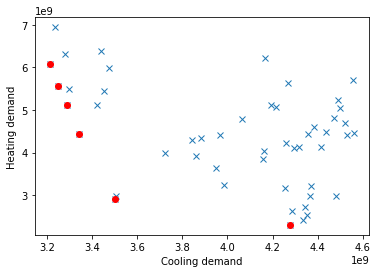

In [9]:
optres = results.loc[results['pareto-optimal']==True,:] # Get only the optimal results
plt.plot(results['DistrictCooling:Facility'], results['DistrictHeating:Facility'],'x') # Plot all results in the background
plt.plot(optres['DistrictCooling:Facility'], optres['DistrictHeating:Facility'],'ro') # Plot optimal results in red
plt.xlabel('Cooling demand')
plt.ylabel('Heating demand')

## Visualize the results

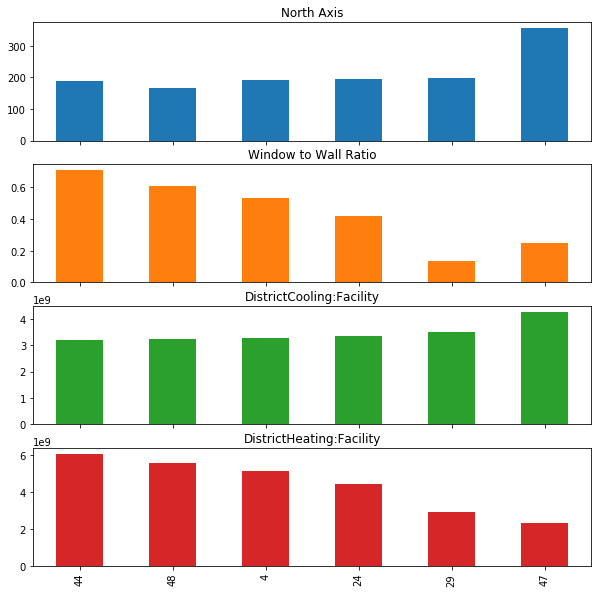

In [10]:
optres = optres.sort_values('DistrictCooling:Facility') # Sort by the first objective 
optresplot = optres.drop(columns='violation') # Remove the constraint violation column
ax=optresplot.plot.bar(subplots=True,legend=None,figsize=(10,10)) # Plot the variable values of each of the optimal solutions

In [11]:
client.restart()

distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:54017 Dashboard: http://127.0.0.1:54020/status,Cluster Workers: 4 Cores: 4 Memory: 8.30 GB
